# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
import time
import ast

from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
start = time.time()

# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Total execution time: 265.82 seconds


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)

(891221, 366)


In [5]:
# print the first 10 rows of the dataset
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [6]:
azdias['ALTERSKATEGORIE_GROB'].describe()

count    891221.000000
mean          2.777398
std           1.068775
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           9.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64

In [10]:
azdias['ALTERSKATEGORIE_GROB'].median()

3.0

In [6]:
azdias['ALTERSKATEGORIE_GROB'].describe(percentiles=[0.80])

count    891221.000000
mean          2.777398
std           1.068775
min           1.000000
50%           3.000000
80%           4.000000
max           9.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64

In [7]:
# replacing values for CAMEO_DEUG_2015
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X',-1)

In [18]:
azdias['CAMEO_DEUG_2015'].describe()

count     792242
unique        19
top            8
freq       78023
Name: CAMEO_DEUG_2015, dtype: object

In [8]:
azdias['CAMEO_DEUG_2015'].median()

6.0

In [25]:
azdias['HH_EINKOMMEN_SCORE'].describe()

count    872873.000000
mean          4.207243
std           1.624057
min           1.000000
25%           3.000000
50%           5.000000
75%           6.000000
max           6.000000
Name: HH_EINKOMMEN_SCORE, dtype: float64

In [9]:
azdias['HH_EINKOMMEN_SCORE'].median()

5.0

In [8]:
# read the attributes details of the dataset 
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del feat_info['Unnamed: 0']
feat_info.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [9]:
# Fill the attribute column where the values are NaNs using ffill
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [10]:
# Get the encoded values that are actually missing or unknown values 
# Subset the meaning column to contain only those values using "unknown" or "no " terms 
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 500)
feat_info


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [11]:
# Convert to a list of strings
feat_info.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [12]:
# Because both of the first 2 rows of feat_info belong to the same attribute, combine the values 
# for each row into a single list of strings

unknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']

In [13]:
feat_info = unknowns
feat_info

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [14]:
start = time.time()

# Converting the missing values to Nans in the dataset
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
azdias[azdias.isin(missing_values)] = np.nan

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 451.64 seconds


In [15]:
azdias.shape

(891221, 366)

In [31]:
#azdias.head(10)

In [16]:
start = time.time()

# Checking how much missing data there is in each column of the dataset.
missing_col = azdias.isnull().sum()

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 110.18 seconds


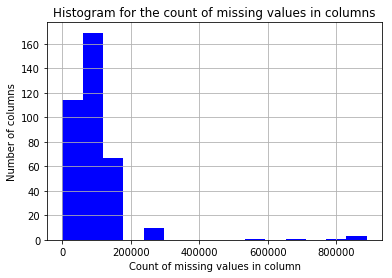

In [20]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_col, bins=15, facecolor='b', alpha=1)
plt.xlabel('Count of missing values in column')
plt.ylabel('Number of columns')
plt.title('Histogram for the count of missing values in columns')
plt.grid(True)
plt.show()

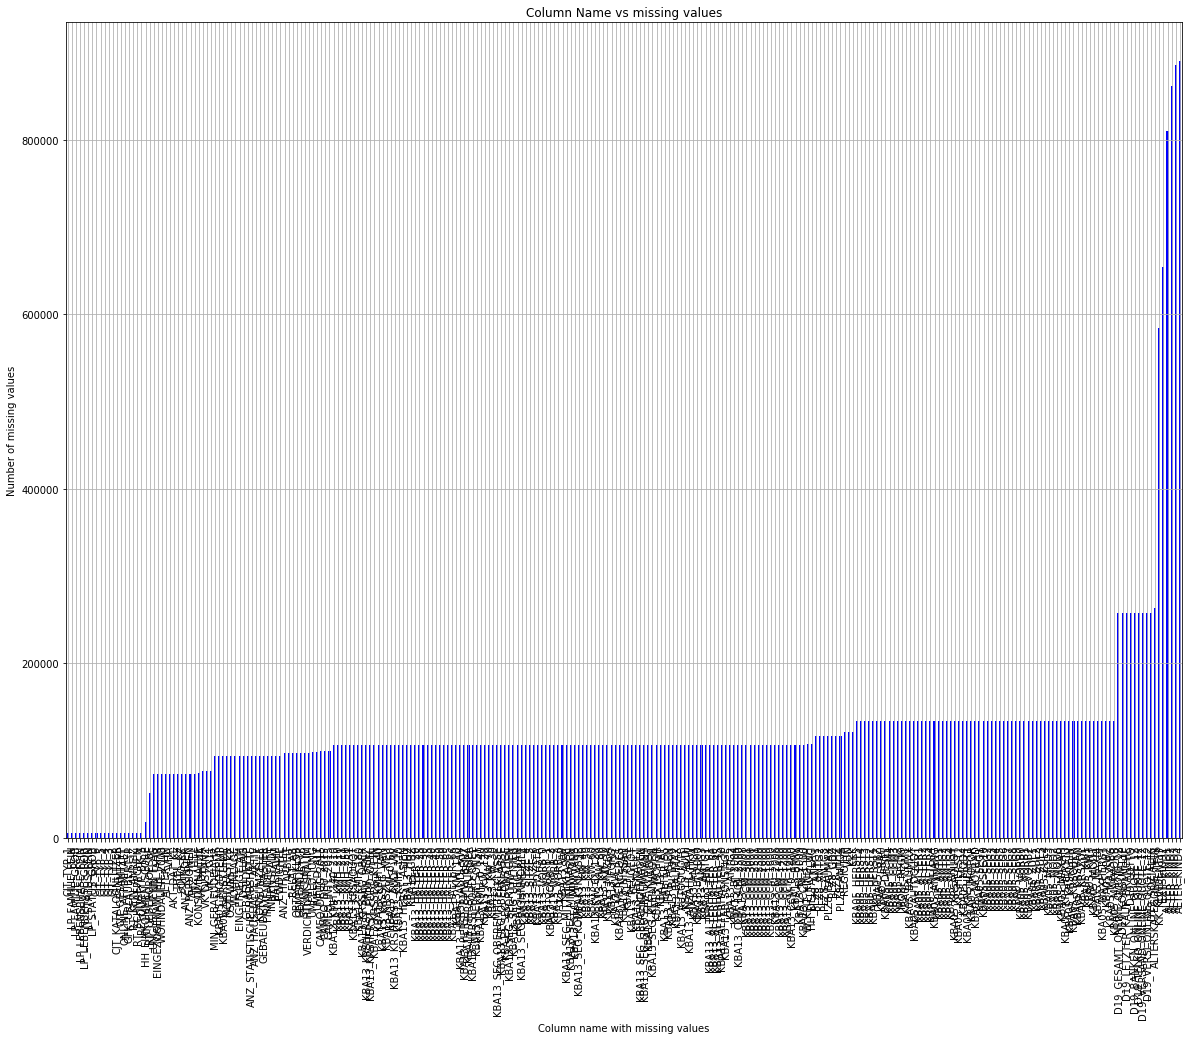

In [21]:
missing_columns = missing_col[missing_col>0]
missing_columns.sort_values(inplace=True)
missing_columns.plot.bar(figsize=(20,15), facecolor='b')
plt.xlabel('Column name with missing values')
plt.ylabel('Number of missing values')
plt.grid(True)
plt.title('Column Name vs missing values')
plt.show()

In [17]:
start = time.time()

# This operation is to remove the outlier columns from the dataset. 

 # identify the columns having more than 20K missing values
missing_col_updated = missing_col[missing_col>200000]

# dropping those columns from the data set
azdias.drop(missing_col_updated.index, axis=1, inplace=True) 

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 71.32 seconds


In [18]:
# listing the dropped columns
print(missing_col_updated)

ALTER_KIND1                    810163
ALTER_KIND2                    861722
ALTER_KIND3                    885051
ALTER_KIND4                    890016
ALTERSKATEGORIE_FEIN           262947
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_SOZIALES                   257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
D19_VERSI_ONLINE_QUOTE_12      257113
EXTSEL992                      654153
KK_KUNDENTYP                   584612
dtype: int64


In [24]:
azdias.shape

(891221, 350)

In [19]:
start = time.time()

# Separate the data into two subsets based on the number of missing # values in each row.
# Keep the the rows having less than 20 missing values for the analyis 
n_missing = azdias.isnull().transpose().sum()
azdias_missing_low = azdias[n_missing<20] # rows having less than 20 missing values 
#azdias_missing_high = azdias[n_missing>=20]; # rows having more or equal to 20 missing values  
n_missing_low = azdias_missing_low.isnull().transpose().sum()
#n_missing_high = azdias_missing_high.isnull().transpose().sum()

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 130.19 seconds


In [20]:
# check the count for remaining number of rows 
azdias_missing_low.shape

(746902, 350)

In [21]:
# The only binary categorical variable that does not take integer values is OST_WEST_KZ which uses either W or O
# Re-encoding with 1 and 0. 

azdias_missing_low['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias_missing_low['OST_WEST_KZ'].head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [22]:
# For columns > 10 different values, drop for # simplicity. 
cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE','EINGEFUEGT_AM']

# For columns < 10 levels, re-encode using dummy variables.
cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [23]:
start = time.time()

# Dropping the categorical columns 
azdias_missing_low.drop(cat_cols_to_drop, axis=1, inplace = True)

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 97.84 seconds


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
start = time.time()

# Creating dummy variables for columns with less than 10 categories unique values 
# then drop the original columns


for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias_missing_low[col], prefix = col)
    azdias_missing_low = pd.concat([azdias_missing_low, dummy], axis = 1)

print("Dropping the dummied columns")
azdias_missing_low.drop(cat_cols_to_dummy, axis=1, inplace = True)


end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))


Dropping the dummied columns
Total execution time: 1408.53 seconds


In [25]:
print(azdias_missing_low.shape)

(746902, 398)


In [26]:
# replacing values for CAMEO_INTL_2015
azdias_missing_low['CAMEO_INTL_2015'] = azdias_missing_low['CAMEO_INTL_2015'].replace('XX',-1)

In [27]:
# replacing values for CAMEO_DEUG_2015
azdias_missing_low['CAMEO_DEUG_2015'] = azdias_missing_low['CAMEO_DEUG_2015'].replace('X',-1)

In [28]:
# Create a cleaning function so the same changes can be done on the customer dataset as it was on the
# general population dataset. 

def clean_data(azdias, feat_info):
    """
   
    INPUT: 
        azdias: Population/Customer demographics DataFrame
        feat_info: feat info DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
   
    # Convert missing values to Nans
    print("Convert missing values")
    missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
    azdias[azdias.isin(missing_values)] = np.nan

    missing_col = azdias.isnull().sum()

    print("dropping missing_col_updated")

    # Remove the outlier columns from the dataset
    missing_col_updated = missing_col[missing_col>200000] #taking out the columns having more than 20K missing values
    azdias.drop(missing_col_updated.index, axis=1, inplace=True) # dropping those columns from the data set
    
    n_missing = azdias.isnull().transpose().sum()
    azdias_missing_low = azdias[n_missing<20] # rows having less than 20 missing values 
    n_missing_low = azdias_missing_low.isnull().transpose().sum()
    
    # The only binary categorical variable that does not take integer values is OST_WEST_KZ which uses either W or O

    print("replacing values for OST_WEST_KZ")

    azdias_missing_low['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    azdias_missing_low['OST_WEST_KZ'].head()
    
    # For columns > 10 different values, drop for # simplicity. 
    # For columns < 10 levels, re-encode using dummy variables.
    
    cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE','EINGEFUEGT_AM']

    cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    
    print("Dropping categorical columns with 10 or more values")
    # Drop categorical columns with 10 or more values
    azdias_missing_low.drop(cat_cols_to_drop, axis=1, inplace = True)
   
    
    for col in cat_cols_to_dummy:
        dummy = pd.get_dummies(azdias_missing_low[col], prefix = col)
        azdias_missing_low = pd.concat([azdias_missing_low, dummy], axis = 1)

    print("Dropping dummies")
    azdias_missing_low.drop(cat_cols_to_dummy, axis=1, inplace = True)
    
    # replacing values for CAMEO_INTL_2015
    azdias_missing_low['CAMEO_INTL_2015'] = azdias_missing_low['CAMEO_INTL_2015'].replace('XX',-1)
    
    # replacing values for CAMEO_DEUG_2015
    azdias_missing_low['CAMEO_DEUG_2015'] = azdias_missing_low['CAMEO_DEUG_2015'].replace('X',-1)
    
    
    # Return the cleaned dataframe.
    return azdias_missing_low


In [29]:
azdias_missing_low.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_-1,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_-1,VERS_TYP_1,VERS_TYP_2
1,910220,-1,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0,0,0,0,0,0,1,0,0,1
2,910225,-1,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,910226,2,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,910241,-1,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0,0,0,0,0,1,0,0,0,1
5,910244,3,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1
6,910248,-1,9.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,...,0,0,0,0,1,0,0,0,1,0
7,910261,-1,1.0,14.0,6.0,0.0,0.0,1.0,5.0,0.0,...,0,0,0,1,0,0,0,0,1,0
8,645145,-1,9.0,16.0,2.0,1.0,0.0,1.0,2.0,0.0,...,0,0,0,0,0,0,1,0,0,1
9,645153,-1,5.0,17.0,9.0,0.0,0.0,1.0,7.0,0.0,...,0,0,0,0,0,0,1,0,0,1
10,645165,0,1.0,10.0,6.0,0.0,0.0,1.0,6.0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [30]:
start = time.time()

azdias_missing_low=azdias_missing_low.fillna(0)

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 23.27 seconds


In [31]:
scaler = StandardScaler()

In [ ]:
# Apply feature scaling to the population  data.
start = time.time()

azdias_missing_low = pd.DataFrame(scaler.fit_transform(azdias_missing_low), columns = azdias_missing_low.columns)

end = time.time()
print("Total execution time: {:.2f} seconds".format(end-start))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [32]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
customers.shape

(191652, 369)

In [34]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [35]:
start = time.time()

# Run the clean_data function on the population dataset
customers = clean_data(customers, feat_info)

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))


Convert missing values
dropping missing_col_updated
replacing values for OST_WEST_KZ


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Dropping categorical columns with 10 or more values


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dropping dummies
Total execution time: 37.73 seconds


In [36]:
customers.shape

(132077, 416)

In [37]:
start = time.time()

customers=customers.fillna(0)

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 0.53 seconds


In [38]:
# Drop the extra columns of customers dataset.
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [39]:
cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']

customers.drop(cols_to_drop, axis=1, inplace = True)

In [40]:
customers.shape

(132077, 366)

In [41]:
# Apply feature scaling to the population  data.
start = time.time()

customers = pd.DataFrame(scaler.fit_transform(customers), columns = customers.columns)

end = time.time()
print("Total execution time: {:.2f} seconds".format(end-start))

Total execution time: 13.63 seconds


In [42]:
customers.head(10)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_-1,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_-1,VERS_TYP_1,VERS_TYP_2
0,-1.560024,-0.352994,-0.280006,-0.126857,-0.265124,-0.200215,-0.263891,-0.134295,-1.777323,-0.615279,...,-0.129184,-0.099003,-0.127998,-0.531261,-0.582838,-0.444482,1.377177,-0.127998,1.025111,-0.992585
1,0.864474,-0.352994,-0.280006,-0.126857,-0.265124,-0.914007,-0.263891,-0.134295,0.178433,1.275235,...,-0.129184,-0.099003,-0.127998,-0.531261,1.715743,-0.444482,-0.726123,-0.127998,-0.975504,1.007471
2,0.864492,-0.352994,-0.351300,-0.126857,-0.265124,-1.627798,-0.263891,-0.134295,-1.777323,1.275235,...,-0.129184,-0.099003,-0.127998,1.882312,-0.582838,-0.444482,-0.726123,-0.127998,1.025111,-0.992585
3,0.864510,-0.352994,0.147758,-0.126857,-0.265124,1.227368,0.168098,-0.134295,0.178433,-0.615279,...,-0.129184,-0.099003,-0.127998,-0.531261,1.715743,-0.444482,-0.726123,-0.127998,-0.975504,1.007471
4,0.864763,-0.352994,-0.280006,-0.126857,-0.265124,-0.200215,-0.263891,-0.134295,0.178433,1.275235,...,-0.129184,-0.099003,-0.127998,-0.531261,1.715743,-0.444482,-0.726123,-0.127998,-0.975504,1.007471
5,0.865052,-0.352994,-0.280006,-0.126857,-0.265124,-0.200215,-0.263891,-0.134295,-0.799445,0.802606,...,-0.129184,-0.099003,-0.127998,1.882312,-0.582838,-0.444482,-0.726123,-0.127998,1.025111,-0.992585
6,0.865160,-0.352994,-0.280006,-0.126857,-0.265124,-0.200215,-0.263891,-0.134295,0.178433,0.329978,...,-0.129184,-0.099003,-0.127998,-0.531261,-0.582838,-0.444482,1.377177,-0.127998,1.025111,-0.992585
7,0.111150,0.736861,4.924457,3.800683,-0.265124,-0.914007,5.567962,-0.134295,0.178433,-0.615279,...,-0.129184,-0.099003,-0.127998,-0.531261,-0.582838,-0.444482,1.377177,-0.127998,-0.975504,1.007471
8,0.111385,-0.352994,-0.280006,-0.126857,-0.265124,0.513576,-0.263891,-0.134295,0.178433,-1.087908,...,-0.129184,-0.099003,-0.127998,1.882312,-0.582838,-0.444482,-0.726123,-0.127998,-0.975504,1.007471
9,0.111602,-0.352994,-0.280006,-0.126857,-0.265124,-0.914007,-0.263891,-0.134295,-0.799445,0.802606,...,-0.129184,-0.099003,-0.127998,1.882312,-0.582838,-0.444482,-0.726123,-0.127998,1.025111,-0.992585


In [43]:
# Apply PCA to the population data.
start = time.time()

pca = PCA()
customers = pca.fit_transform(customers)

end = time.time()
print("Total execution time: {:.2f} seconds".format(end-start))

Total execution time: 14.74 seconds


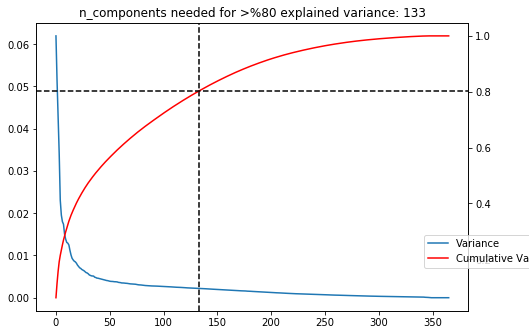

In [44]:
# Investigate the variance accounted for by each principal component.
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1) # 80% of variance selected

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'red');
ax.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.8,0.2));

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
start = time.time()

pca = PCA(n_components=60, random_state=10)
azdias_pca = pca.fit_transform(customers)

end = time.time()
print("Total execution time of this procedure: {:.2f} seconds".format(end-start))

Total execution time of this procedure: 11.04 seconds


In [46]:
# check the sum of the explained variance
pca.explained_variance_ratio_.sum()

0.59490173770901977

In [47]:
def plot_pca(data, pca, n_components):
    '''
	Plot the features with the most absolute variance for given pca component 
	'''
    compo = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_components-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(5), compo.tail(5)])
    
    compo.plot(kind='bar', title='Component ' + str(n_components))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

In [ ]:
# plot_pca(customers, pca, 2)

In [48]:
from sklearn.cluster import KMeans, MiniBatchKMeans

start = time.time()

kmeans_scores = []
for i in range(2,30,2):

    #run k-means clustering on the data 
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(azdias_pca)
    
    #compute the average within-cluster distances.
    #print(i,kmeans.score(azdias_pca))
    kmeans_scores.append(-kmeans.score(azdias_pca))

end = time.time()
print("Total execution time: {:.2f} seconds".format(end-start))

Total execution time: 10.08 seconds


In [50]:
kmeans_scores

[26775501.115425918,
 25278124.514218625,
 22783544.581777353,
 21978955.74652512,
 21890744.256081361,
 20880455.579594832,
 20213606.9170308,
 19860155.318103127,
 21910629.017021239,
 19820776.611837707,
 19220696.224666141,
 19970675.451536715,
 19039771.866311256,
 19830786.835803676]

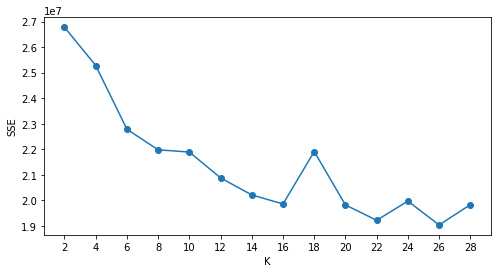

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plot elbow plot
x = range(2, 30, 2)
plt.figure(figsize=(8, 4))
plt.plot(x, kmeans_scores, marker='o')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('SSE');

In [51]:
# Re-fit the k-means model with the selected number of clusters (20) and obtain
# cluster predictions for the general population demographics data.
start = time.time()

kmeans_20 = KMeans(20, random_state=10)
clusters_pop = kmeans_20.fit_predict(azdias_pca)

end = time.time()
print("Total execution time of this procedure: {:.2f} seconds".format(end-start))

Total execution time of this procedure: 115.93 seconds


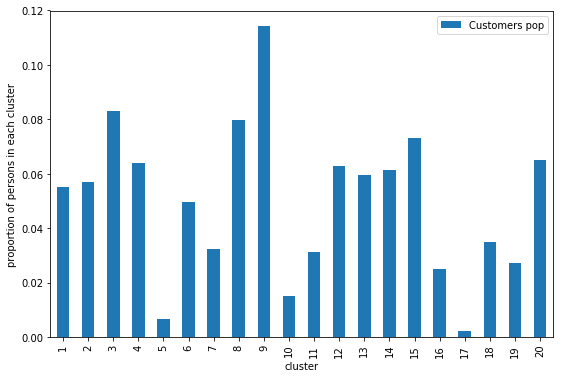

In [52]:
#general_prop = []
customers_prop = []
x = [i+1 for i in range(20)]
for i in range(20):
    #general_prop.append((clusters_pop == i).sum()/len(clusters_pop))
    customers_prop.append((clusters_pop == i).sum()/len(clusters_pop))


df_general = pd.DataFrame({'cluster' : x, 'Customers pop':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['Customers pop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [53]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [55]:
mailout_train.shape

(42962, 367)

In [56]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [57]:
# Imbalance of REPONSE column
vc = mailout_train['RESPONSE'].value_counts()
vc

0    42430
1      532
Name: RESPONSE, dtype: int64

In [58]:
# positive response
vc[1]/(vc[0]+vc[1])

0.012383036171500396

In [59]:
# negative response
vc[0]/(vc[0]+vc[1])

0.98761696382849962

In [60]:
mailout_train.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


In [61]:
# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

(array([ 114.,    0.,    0.,    0.,    0.,   16.,  229.,    2.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.,    3.]),
 array([ 0.        ,  0.0293837 ,  0.05876739,  0.08815109,  0.11753478,
         0.14691848,  0.17630218,  0.20568587,  0.23506957,  0.26445327,
         0.29383696,  0.32322066,  0.35260435,  0.38198805,  0.41137175,
         0.44075544,  0.47013914,  0.49952283,  0.52890653,  0.55829023,
         0.58767392,  0.61705762,  0.64644131,  0.67582501,  0.70520871,
         0.7345924 ,  0.7639761 ,  0.7933598 ,  0.82274349,  0.85212719,
         0.88151088,  0.91089458,  0.94027828,  0.96966197,  0.99904567]),
 <a list of 34 Patch objects>)

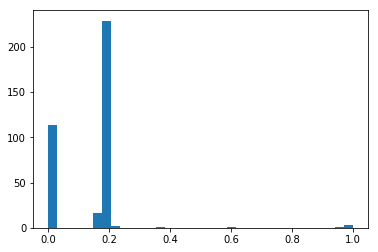

In [62]:
plt.hist(missing_per_column, bins=34)

In [63]:
start = time.time()

# clean data, no splitting of rows necessary
mailout_train = clean_data(mailout_train, feat_info)
mailout_train.shape

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Convert missing values
dropping missing_col_updated
replacing values for OST_WEST_KZ
Dropping categorical columns with 10 or more values


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dropping dummies
Total execution time: 3.52 seconds


In [64]:
# this columns has data values as time
mailout_train.drop(labels=['D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)

In [65]:
mailout_train.shape

(33627, 413)

In [69]:
mailout_train.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_-1,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,VERS_TYP_-1,VERS_TYP_1,VERS_TYP_2
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,0,0,0,0,0,0,1,0,0,1
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1,0,0,0,0,1,0,0,1,0
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,0,0,0,0,0,0,1,0,1,0
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,0,0,0,0,1,0,0,0,0,1
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,0,0,0,0,1,0,0,0,1,0
5,1789,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,0,0,0,0,0,0,1,0,1,0
6,1795,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,0,0,0,1,0,0,0,0,0,1
7,1493,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0,0,0,1,0,0,0,0,1,0
11,2512,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,0,0,0,0,0,1,0,0,1,0
12,2513,1,1.0,15.0,NaN,NaN,NaN,NaN,8.0,1.0,...,0,1,0,0,1,0,0,0,1,0


In [75]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

In [68]:
# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [71]:
# impute median and scale azdias
imputer = Imputer(strategy='median')
scaler = StandardScaler()

In [72]:
mailout_train_imputed = pd.DataFrame(imputer.fit_transform(mailout_train))
mailout_train_scaled = scaler.fit_transform(mailout_train_imputed)


In [73]:
mailout_train_scaled.shape

(33627, 412)

In [74]:
response.shape

(33627,)

Dataset has been preprocessed for further analysis 

In [78]:
def classify(clf, param_grid, X_train=mailout_train_scaled, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [79]:
start = time.time()

# LogisticRegression
logreg = LogisticRegression(random_state=12)
classify(logreg, {})

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.669752148548
Total execution time: 122.39 seconds


In [80]:
start = time.time()

# BaggingClassifier
bac = BaggingClassifier(random_state=12)
classify(bac, {})

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.586992194594
Total execution time: 180.17 seconds


In [81]:
start = time.time()

# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=12)
abc_best_est = classify(abc, {})


end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.771348891187
Total execution time: 141.47 seconds


In [82]:
start = time.time()

# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=12)
classify(gbc, {})

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.770407792289
Total execution time: 672.09 seconds


In [ ]:
# Tuning the model which gave the best result

In [83]:
# tune with the help of GridSearchCV
# the result is our model that will be used with the test set
gbc = GradientBoostingClassifier(random_state=12)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[80],
              'random_state': [12]
             }

start = time.time()

gbc_tuned = classify(gbc, param_grid)
gbc_tuned

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.781698508941
Total execution time: 1516.39 seconds


In [77]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=12)
skf.get_n_splits(mailout_train, response)
print(skf)

StratifiedKFold(n_splits=5, random_state=12, shuffle=False)


In [85]:
def create_pipeline(clf):
    
    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])
    
    return pipeline

In [86]:
def cross_validate(clf):

    pipeline = create_pipeline(clf)
    scores = []
    i = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(mailout_train, response):
        i+=1
        print('Fold {}'.format(i))
        
        # Split the data into training and test sets
        X_train, X_test = mailout_train.iloc[train_index], mailout_train.iloc[test_index]
        y_train, y_test = response.iloc[train_index], response.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print("Score: {}".format(score))
        
    return scores

In [91]:
from sklearn.metrics import roc_auc_score

start = time.time()

tuned_scores = cross_validate(gbc)

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Fold 1
Score: 0.4995483288166215
Fold 2
Score: 0.5054254312384393
Fold 3
Score: 0.5
Fold 4
Score: 0.49992471013401596
Fold 5
Score: 0.4994729709381117
Total execution time: 242.16 seconds


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [40]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [43]:
mailout_test.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
5,1782,2,1.0,7.0,NaN,NaN,NaN,NaN,7.0,66.0,...,4.0,9.0,10.0,7.0,6.0,9.0,3.0,6,1,4
6,1485,2,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,1.0,2.0,1.0,6.0,9.0,3.0,3,2,4
7,1519,-1,1.0,20.0,NaN,NaN,NaN,NaN,15.0,1.0,...,2.0,4.0,5.0,4.0,2.0,9.0,3.0,4,2,3
8,1835,1,1.0,19.0,NaN,NaN,NaN,NaN,13.0,2.0,...,1.0,1.0,1.0,1.0,4.0,9.0,7.0,1,2,3
9,1522,1,1.0,0.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,5.0,8.0,9.0,3.0,4.0,2.0,4,1,3


In [45]:
# extract lnr for later generation of the competition result file
# lnr = mailout_test.LNR

In [46]:
# clean data
mailout_test = clean_data(mailout_test, feat_info)
mailout_test.shape

Convert missing values
dropping missing_col_updated
replacing values for OST_WEST_KZ
Dropping categorical columns with 10 or more values


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dropping dummies


(33616, 413)

In [47]:
# this columns has data values as time
mailout_test.drop(labels=['D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)

In [54]:
lnr = mailout_test.LNR

In [48]:
mailout_test.shape

(33616, 412)

In [49]:
# impute median and scale azdias 
mailout_test_imputed = pd.DataFrame(imputer.transform(mailout_test))
mailout_test_scaled = scaler.transform(mailout_test_imputed)

In [50]:
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = gbc_tuned.predict_proba(mailout_test_scaled)
response_test

array([[ 0.96878391,  0.03121609],
       [ 0.97094428,  0.02905572],
       [ 0.99609662,  0.00390338],
       ..., 
       [ 0.98183725,  0.01816275],
       [ 0.9792309 ,  0.0207691 ],
       [ 0.98068575,  0.01931425]])

In [53]:
response_test.shape

(33616, 2)

In [55]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.head(10)

,LNR,RESPONSE
0,1754,0.968784
1,1770,0.970944
2,1465,0.996097
3,1470,0.997189
4,1478,0.997197
5,1782,0.996883
6,1485,0.994853
7,1519,0.978785
8,1835,0.981773
9,1522,0.993368
